# Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
import seaborn as sns

First we load the data. We will only be working with the first 1000 images of the train data, so we save and reshape them.

In [4]:
# Load data
def load_data():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # convert labels to categorical samples
  #y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
  return ((x_train, y_train), (x_test, y_test))
  
(x_train, y_train), (x_test, y_test) = load_data()

# Take only the first 1000 images and reshape them
X = x_train[0:1000].reshape(-1, 784)

Now we create a function which standardises the data.

In [5]:
def standardise(X):
  '''
  Input:
    X: ndarray of input data
  Output:
    Returns the standardised data.
  '''

  mu = np.mean(X, axis=0)
  std = np.std(X, axis=0)
  std_filled = std.copy()
  std_filled[std==0] = 1.
  Xbar = ((X-mu)/std_filled)
  return Xbar

We now create a function that takes as an input a dataset and the number of principle components $m$ are performs dimensionality reduction. We then need to perform the following steps, which we break into parts:

*   Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
*   Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
*   Sort by the largest eigenvalues and the corresponding eigenvectors.
*   Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

In [6]:
def PCA(X, m):
  '''
  Input:
    X: ndarray of input data
    m: number of principle components
  Output:
    X_PCA: projection onto the spaced spanned by the eigenvectors.
  '''

  # create covariance matrix
  C = np.dot(X.T, X) / (len(X) - 1)

  # compute eigenvalues and eigenvectors using the eigsh scipy function
  eigenvalues, eigenvectors = linalg.eigsh(C, m) 

  # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
  sorted_index = np.argsort(eigenvalues)[::-1]
  eigenvalues=eigenvalues[sorted_index]
  eigenvectors=eigenvectors[:,sorted_index]

  # transform our data
  X_PCA = X.dot(eigenvectors)

  return X_PCA, eigenvectors, eigenvalues

We now use $m=25$ an our standardised data of the subset of $1000$ images.

In [7]:
# Standardise our data
X = standardise(X)

# choose our number of principle components
m = 25

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = PCA(X, m)

Now we plot the first $25$ eigenvectors reshaped into their original image size for the first $10$ images.

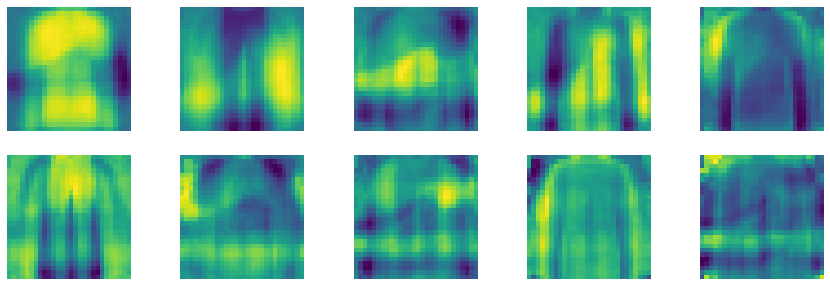

In [8]:
# Plot reshaped eigenvectors
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,5))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28, 28]))
    ax.set_ylabel(str(i))
    ax.axis('off')
plt.show()

While the quality of the images is reduced (due to the dimensionality reduction) we can still distinguish the objects. 

We now plot the eigenvalues as $m$ varies.

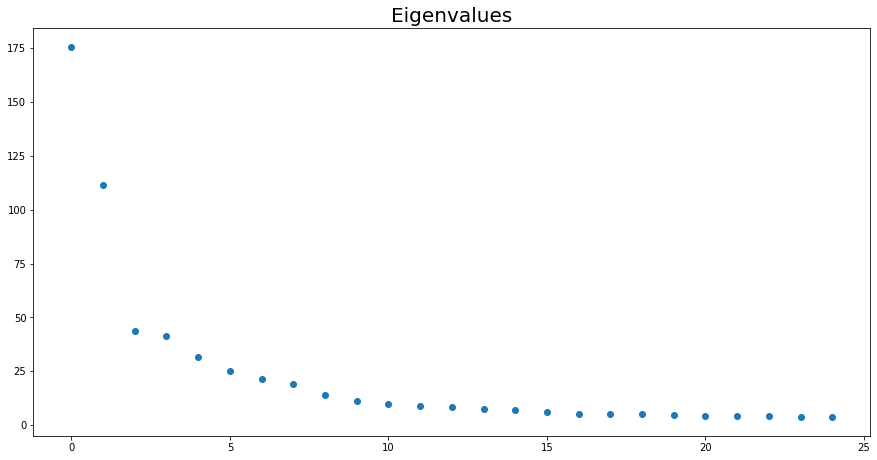

In [9]:
# Plot eigenvalues
plt.figure(figsize=(15, 7.5))
plt.scatter(np.arange(m), eigenvalues)
plt.title("Eigenvalues", size=20)
plt.show()

From the plot we can see that the first two eigenvalues have relatively high values after which there is a drastic drop, leading to the remaining eigenvalues to be quite small. This indicates that $m=2$ could be a good optimal value for the reduced dimension $m$.

Now we compute the fraction of explained variance and then plot it.

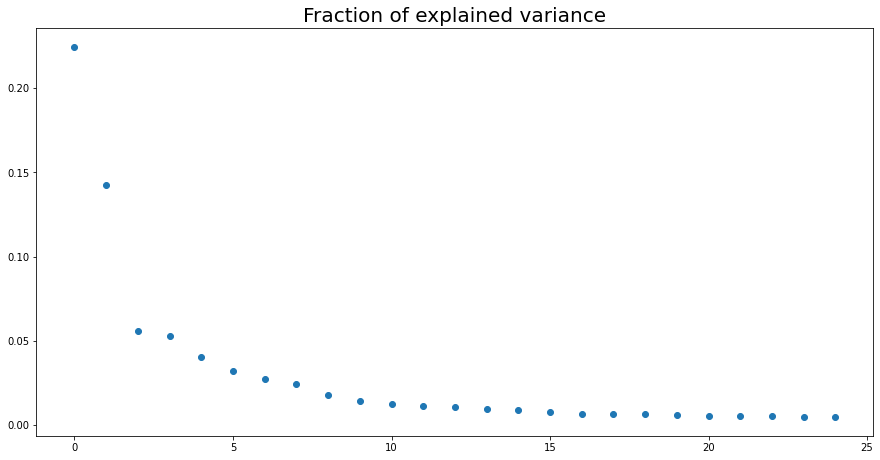

In [10]:
# Compute total variance
C = np.dot(X.T, X) / (len(X)-1)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

# Compute the fraction of explained variance
explained_variances = eigenvalues /  total_variance

# Plot the fraction of explained variance as we vary m
plt.figure(figsize=(15, 7.5))
plt.scatter(np.arange(m), explained_variances)
plt.title("Fraction of explained variance", size=20)
plt.show()

Once again, we can see that there is a drastic drop after the second dot, after which the proportion of explained variance is relatively small. This suggest that $m=2$ is optimal as we deduced from the plot of the eigenvalues. 

We now consider the top $m=2$ principal components and produce a plot of the $N=1000$ data in the PCA space spanned by these $m=2$ components.

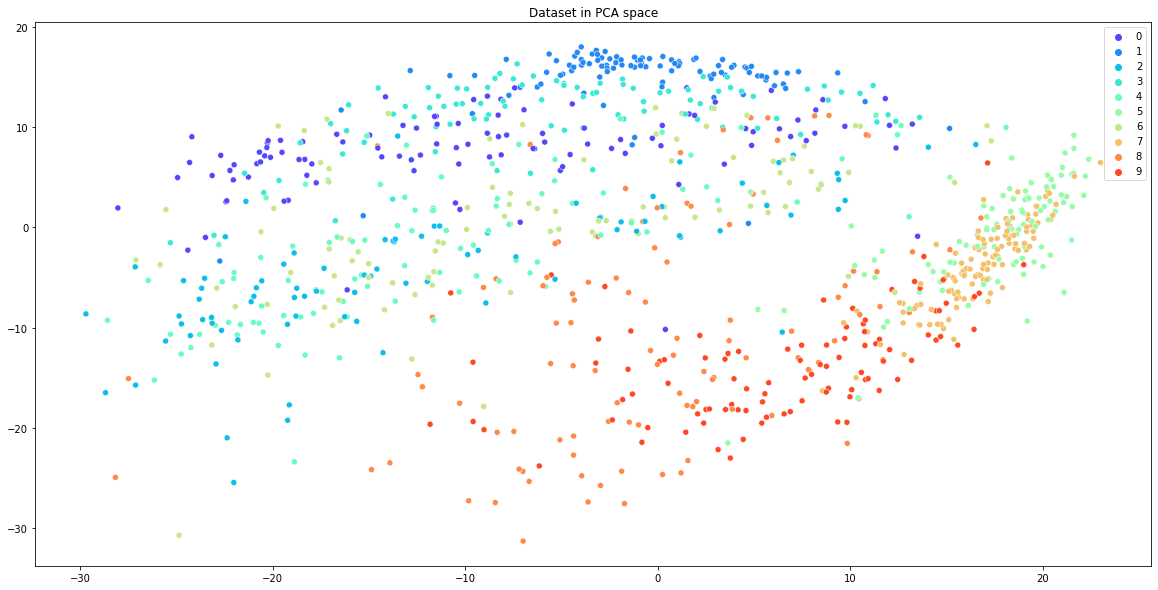

In [11]:
# Fix m=2
m = 2
X_pca, eigenvectors, eigenvalues = PCA(X, m)

# Plot the data on the 2 dimensional space
plt.figure(figsize=(20, 10))
sns.scatterplot(x=X_pca[:, 0], 
                y=X_pca[:, 1], 
                hue=y_train[0:1000],
                palette = sns.color_palette("rainbow", 10))
plt.title("Dataset in PCA space")
plt.legend()
plt.show()

The categories correspond to: 

0.   T-shirt/top
1.   Trouser
2.   Pullover
3.   Dress
4.   Coat
5.   Sandal
6.   Shirt
7.   Sneaker
8.   Bag
9.   Ankle boot

We can see in the plot that the data is separated into two main clusters (with white space between them). If we look closely, the points in one of the clusters correspond to all the shoe types and the other points represent t-shirt, dress, pullover and the rest of the clothes. Intuitively, we recognise that there is a larger distinction between shoes and clothes and that is why it appears that they are in separate clusters. Further, the bag point seems rather spread out in both sides, as it is rather ambiguous to which of the two types in belongs.

We can also see that most of the points from one color are relatively close to each other, indicating that they form clusters which are less obvious to us, but hopefully our algorithm will be able to capture them. 

We now fix $m=2$ and apply the $k$-means clustering algorithm on our data which is described as follows:

1.   Given a number of clusters $k$, assign every sample to one of the $k$ clusters at random
2.   Compute the centroid of each of the $k$ clusters:
$$
\textbf{m}_l = \frac{1}{|c_l|}\sum_{i \in c_l} \textbf{x}^{(i)}, l = 1, ..., k.
$$
3.   Reassign each $\textbf{x}^{(i)}$ to the closest centroid.
4.   Iterate steps $3$ and $4$ until convergence, i.e. until assignments do not change.



In [12]:
def k_means(X, k, max_iterations=100):
  '''
  Input: 
    X: datapoints
    k: parameter for k means clustering
    max_iterations: max number of times we update the centroids
    Output:
      W: sum of distances of each point to its centroid
      labels: final produced labels
      centroids: final centroids
  '''
  # labels: assign every sample to a cluster at random
  labels = np.random.randint(low=0, high=k, size=X_pca.shape[0])
  X_labels = np.append(X, np.reshape(labels, (-1,1)), axis=1)

  # computing the centroids of each of the k clusters
  centroids = np.zeros((k, X.shape[1]))
  for i in range(k):
      centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2]


  new_labels = np.zeros(len(X))
  difference = 0

  # k-means algorithm
  for i in range(max_iterations):

      # distances: between data points and centroids
      distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])

      # new_labels: computed by finding centroid with minimal distance
      new_labels = np.argmin(distances, axis=0)

      if (labels==new_labels).all():

          # labels unchanged
          labels = new_labels
          break

      else:

          # difference: percentage of changed labels
          difference = np.mean(labels!=new_labels)

          # labels changed
          labels = new_labels

          for c in range(k):

              # update centroids by taking the mean over associated data points
              if (labels == c).any():
                  centroids[c] = np.mean(X[labels==c], axis=0)

  # Compute the sum of distances of each point to its centroid
  W = 0
  for i in range(X.shape[0]):
    W += np.linalg.norm(X[i] - centroids[labels[i]])**2

  # Return the distance, the labels and the centroids 
  return W, labels, centroids

Now to choose the optimal $k$ we scan over the range $[2, 10]$ and plot the sum of distances of each point to its centroid $W$ vs each $k$.

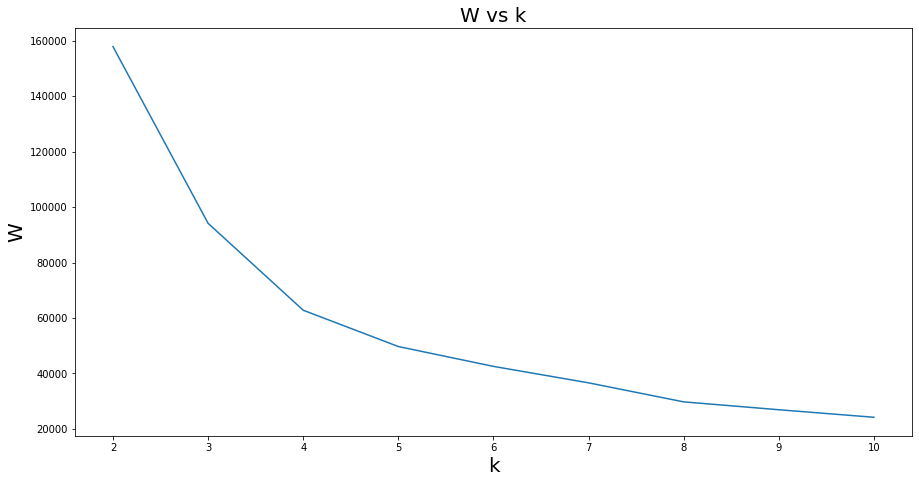

In [13]:
# Fix m=2
m = 2
X_pca, eigenvectors, eigenvalues = PCA(X, m)

# Initialize list of W
W_list = []

# Loop over k in [2, 10]
k_range = np.arange(2,11)
for k in k_range:
  W_list.append(k_means(X_pca, k)[0])

# Plot W vs k
plt.figure(figsize=(15,7.5))
plt.plot(k_range, W_list)
plt.title("W vs k", size=20)
plt.xlabel("k", size=20)
plt.ylabel("W", size=20)
plt.show()

We look for the 'elbow' of the curve and we can see that $k=4$ is the optimal value of $k$. Larger values of $k$ bring no significant improvement.

Now we plot the data in the 2-dimensional space with coloring according to the predicted image class.

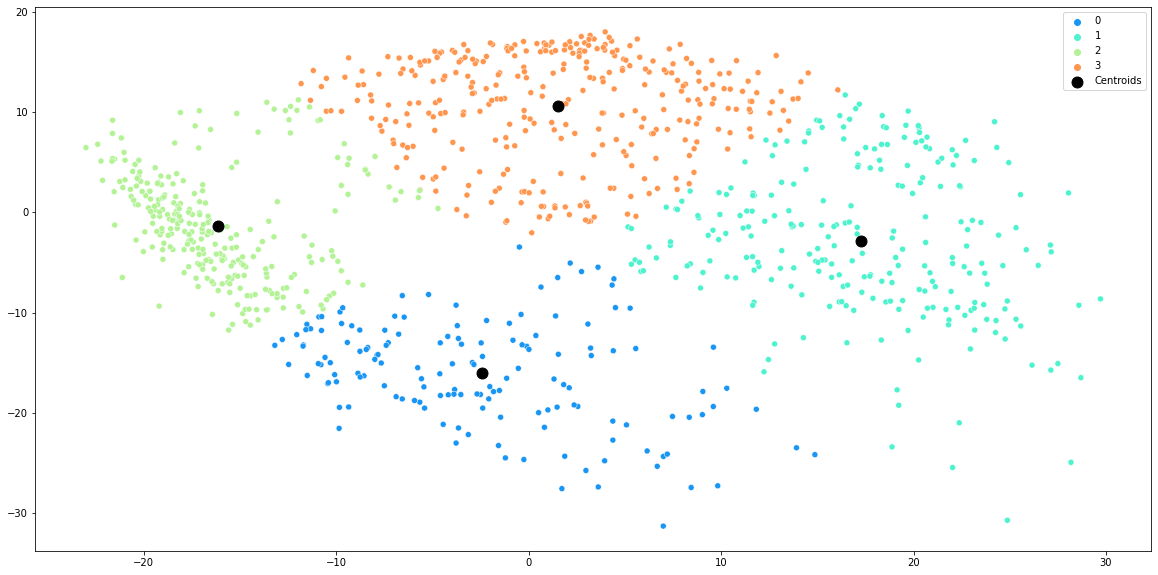

In [14]:
# optimal number of clusters k
k = 4

# Compute the labels and the centroids
_, labels, centroids = k_means(X_pca, k)

# Plot data
plt.figure(figsize=(20, 10))
sns.scatterplot(x=X_pca[: ,0], 
                y=X_pca[:, 1], 
                hue=labels,
                palette = sns.color_palette("rainbow", k))
# Plot centroids
plt.scatter(centroids[:, 0],
            centroids[:, 1], 
            c='black', 
            marker='o', 
            s=120, 
            label="Centroids")
plt.legend()
plt.show()

Ideally, the optimal $k$ would have been equal to $10$ as that is the number of categories we had in the original data. However, because of the dimensionality reduction, some of the information provided by the data is lost, and the k means clustering algorithm produces only four cluster plotted above.

In the above clusters we can notice for example that the sandals and the sneakers are mostly in the top right cluster. Simiarly, the pullover, shirt, dress, coat and T-shirt are in the bottom two clusters, so one can say that while we have not categorised the data into the original ten categories, we have combined some of them to produce four new categories with common characteristics, for instance shoes and tops. 